In [12]:
import os  # Importing the os module for interacting with the operating system
import pandas as pd  # Importing pandas for data manipulation and analysis
import numpy as np  # Importing numpy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing seaborn for statistical data visualization
import cv2  # Importing OpenCV for image processing

import tensorflow as tf  # Importing TensorFlow for deep learning functionalities
from tensorflow.keras.models import Sequential  # Importing Sequential model for creating neural networks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input  # Importing layers for building CNNs
from tensorflow.keras.utils import to_categorical  # Importing to_categorical for converting labels to one-hot encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importing ImageDataGenerator for image augmentation
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# Define paths to your existing folders
train_dir = 'train'
test_dir = 'test'

# Verify the structure
print("Training data:")
print(os.listdir(train_dir))
print("\nTesting data:")
print(os.listdir(test_dir))

# Optional: Print number of images in each category
print("\nNumber of images in each category:")
print(f"Train - Infected: {len(os.listdir(os.path.join(train_dir, 'infected')))}")
print(f"Train - Not Infected: {len(os.listdir(os.path.join(train_dir, 'notinfected')))}")
print(f"Test - Infected: {len(os.listdir(os.path.join(test_dir, 'infected')))}")
print(f"Test - Not Infected: {len(os.listdir(os.path.join(test_dir, 'notinfected')))}")

Training data:
['infected', 'notinfected']

Testing data:
['infected', 'notinfected']

Number of images in each category:
Train - Infected: 781
Train - Not Infected: 1143
Test - Infected: 788
Test - Not Infected: 1145


In [7]:
# Defining image dimensions and parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    rotation_range=20,           # Randomly rotate images
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Strategy for filling in newly created pixels
)

# Creating ImageDataGenerator for testing data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Using lowercase folder names
train_dir = "train"  
test_dir = "test"    

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Create testing data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Print information about the generators
print("\nTraining Data:")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Total training samples: {len(train_generator.classes)}")

print("\nTesting Data:")
print(f"Steps per epoch: {len(test_generator)}")
print(f"Total testing samples: {len(test_generator.classes)}")

Found 1924 images belonging to 2 classes.


Found 1933 images belonging to 2 classes.

Training Data:
Number of classes: 2
Class indices: {'infected': 0, 'notinfected': 1}
Steps per epoch: 61
Total training samples: 1924

Testing Data:
Steps per epoch: 61
Total testing samples: 1933


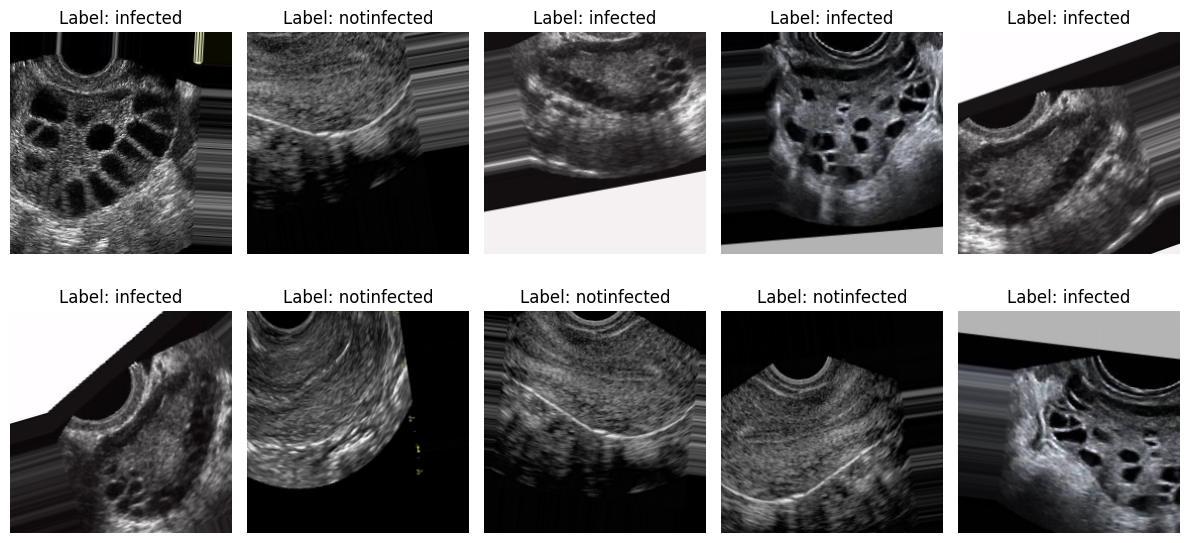

In [8]:
# Define a helper function to visualize images with labels
def visualize_samples_from_generator(generator, num_samples=10):
    """
    Visualizes a grid of sample images with their corresponding labels from a data generator.

    Parameters:
    - generator: ImageDataGenerator object that yields image batches
    - num_samples: number of images to display
    """
    plt.figure(figsize=(12, 6))
    image_batch, label_batch = next(generator)

    for i in range(num_samples):
        if i % 32 == 0 and i != 0:  # Move to the next batch after 32 images
            batch += 1
            image_batch, label_batch = next(generator)  # Fetch next batch

        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(image_batch[i % 32])  # Display image from the batch
        label = label_batch[i % 32]
        plt.title(f"Label: {'infected' if label == 0 else 'notinfected'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample images from the training generator
visualize_samples_from_generator(train_generator)


In [9]:
# Define the CNN model
model1 = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # 32 filters, 3x3 kernel
    MaxPooling2D(pool_size=(2, 2)),  # Downsampling with 2x2 pooling

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),  # 64 filters, 3x3 kernel
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),  # 128 filters, 3x3 kernel
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully Connected Layer 1
    Dense(128, activation='relu'),  # 128 neurons
    Dropout(0.5),  # Dropout to prevent overfitting

    # Fully Connected Layer 2 (Output Layer)
    Dense(1, activation='sigmoid')  # Binary classification (infected or not)
])

# Compile the model
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Summary of the model
model1.summary()


d:\Desktop\AI_projects\pcos_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Define the CNN model with proper input shape
model2 = Sequential([
    # Input layer
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  # 3 for RGB channels
    
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the feature maps
    Flatten(),
    
    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Output Layer
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# checking the image if there is any problem
from PIL import Image  # Importing Image class from PIL for image handling
import os  # Importing os module for interacting with the file system

def check_images(directory):
    """
    Checks all the images in a directory and its subdirectories to verify if they are corrupt.

    Parameters:
    - directory (str): The path of the directory to check for corrupt images.

    This function walks through the given directory, opens each image, and verifies its integrity. 
    If any image is found to be corrupt, an error message is printed with the image's filename.
    """
    for root, dirs, files in os.walk(directory):  # Walk through the directory and subdirectories
        for file in files:  # Loop through each file in the directory
            try:
                img = Image.open(os.path.join(root, file))  # Open the image
                img.verify()  # Verify if the image is corrupt
            except Exception as e:  # Catch any errors in case the image is corrupt
                print(f"Corrupt image {file}: {e}")  # Print the error message with the corrupt image's name

# Check your train and test directories for corrupt images
check_images(train_dir)  # Check images in the train directory
check_images(test_dir)  # Check images in the test directory


Corrupt image OIP.jpg: cannot identify image file 'test\\infected\\OIP.jpg'
Corrupt image R.jpg: cannot identify image file 'test\\infected\\R.jpg'
Corrupt image WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg: cannot identify image file 'test\\infected\\WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg'
Corrupt image WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg: cannot identify image file 'test\\infected\\WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg'
Corrupt image WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg: cannot identify image file 'test\\infected\\WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg'
Corrupt image WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg: cannot identify image file 'test\\infected\\WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg'
Corrupt image img_0_7.jpg: cannot identify image file 'test\\notinfected\\img_0_7.jpg'
Corrupt image OIP (1).jpg: cannot identify image file 'test\\notinfected\\OIP (1).jpg'
Corrupt image WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg: cannot identify im

In [20]:
# Fixing corrupt images

def fix_images(directory):
    """
    Attempts to fix images in a directory by converting them to the PNG format if they are in a different format.

    Parameters:
    - directory (str): The path of the directory where images need to be fixed.

    This function walks through the given directory and its subdirectories, opens each image, 
    and saves it as a PNG file if the image is in another format (such as .jpeg).
    If the image cannot be fixed, an error message is printed with the image's filename.
    """
    for root, dirs, files in os.walk(directory):  # Walk through the directory and subdirectories
        for file in files:  # Loop through each file in the directory
            try:
                img_path = os.path.join(root, file)  # Get the full path of the image
                img = Image.open(img_path)  # Open the image
                img.save(img_path.replace('.jpeg', '.png'))  # Save the image as a PNG file
                print(f"Fixed image {file}")  # Print success message
            except Exception as e:  # Catch any errors in case the image cannot be fixed
                print(f"Cannot fix image {file}: {e}")  # Print error message with the image's name

# Try fixing images in both train and test directories
fix_images(train_dir)  # Attempt to fix images in the train directory
fix_images(test_dir)  # Attempt to fix images in the test directory



Fixed image img1.jpg
Fixed image img10.jpg
Fixed image img2.jpg
Fixed image img3.jpg
Fixed image img4.jpg
Fixed image img5.jpg
Fixed image img6.jpg
Fixed image img7.jpg
Fixed image img8.jpg
Fixed image img_0_1023.jpg
Fixed image img_0_1033.jpg
Fixed image img_0_1071.jpg
Fixed image img_0_1075.jpg
Fixed image img_0_1079.jpg
Fixed image img_0_1083.jpg
Fixed image img_0_1087.jpg
Fixed image img_0_1088.jpg
Fixed image img_0_1099.jpg
Fixed image img_0_113.jpg
Fixed image img_0_1130.jpg
Fixed image img_0_1141.jpg
Fixed image img_0_1142.jpg
Fixed image img_0_1182.jpg
Fixed image img_0_1195.jpg
Fixed image img_0_1223.jpg
Fixed image img_0_1226.jpg
Fixed image img_0_1234.jpg
Fixed image img_0_1257.jpg
Fixed image img_0_126.jpg
Fixed image img_0_1260.jpg
Fixed image img_0_1272.jpg
Fixed image img_0_1275.jpg
Fixed image img_0_1287.jpg
Fixed image img_0_1290.jpg
Fixed image img_0_1305.jpg
Fixed image img_0_1313.jpg
Fixed image img_0_1324.jpg
Fixed image img_0_1329.jpg
Fixed image img_0_1373.jpg
Fi

In [21]:
# Since there are only few images, we can delete the images that are not in the correct format

def delete_corrupt_images(directory):
    """
    This function will delete the corrupt images in the specified directory.
    It will check all images in the directory and its subdirectories, and delete
    any images that cannot be opened or verified by PIL.

    Parameters:
    - directory (str): The path of the directory to check for corrupt images.
    """
    for root, dirs, files in os.walk(directory):  # Walk through the directory and subdirectories
        for file in files:  # Loop through each file in the directory
            img_path = os.path.join(root, file)  # Get the full path of the image
            try:
                img = Image.open(img_path)  # Try to open the image
                img.verify()  # Check if the image is valid
            except Exception as e:  # If there is an exception, the image is corrupt
                # If image is corrupted, delete it
                print(f"Deleting corrupt image: {file}")  # Print which image is being deleted
                os.remove(img_path)  # Delete the corrupt image

# Check and delete corrupted images in the test directory
delete_corrupt_images("test")  # Check and delete corrupt images in the test directory

# Check and delete corrupted images in the train directory
delete_corrupt_images("train")  # Check and delete corrupt images in the train directory



Deleting corrupt image: OIP.jpg
Deleting corrupt image: R.jpg
Deleting corrupt image: WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg
Deleting corrupt image: WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg
Deleting corrupt image: WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg
Deleting corrupt image: WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg
Deleting corrupt image: img_0_7.jpg
Deleting corrupt image: OIP (1).jpg
Deleting corrupt image: WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg
Deleting corrupt image: WhatsApp Image 2022-04-01 at 3.39.07 PM.jpeg


In [23]:
def verify_data_structure():
    """
    Verifies the existence of directories and prints the available image files.
    """
    # Check if directories exist
    if not os.path.exists(train_dir):
        raise ValueError(f"Training directory '{train_dir}' does not exist")
    if not os.path.exists(test_dir):
        raise ValueError(f"Test directory '{test_dir}' does not exist")
    
    # Print available files
    print("Training files:")
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            print(f"{class_name}: {len(files)} files")
            print(f"Sample files: {files[:5]}")  # Print first 5 files
    
    print("\nTest files:")
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            print(f"{class_name}: {len(files)} files")
            print(f"Sample files: {files[:5]}")  # Print first 5 files

# Verify data before training
verify_data_structure()

Training files:
infected: 781 files
Sample files: ['img1.jpg', 'img10.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg']
notinfected: 1144 files
Sample files: ['Copy of img_0_9989.jpg', 'img1.jpeg', 'img1.png', 'img2.png', 'img3.jpg']

Test files:
infected: 782 files
Sample files: ['A_google_image_1.png', 'img1.jpg', 'img10.jpg', 'img2.jpg', 'img3.jpg']
notinfected: 1142 files
Sample files: ['img1.jpeg', 'img1.png', 'img2.png', 'img3.jpg', 'img4.jpg']


In [26]:
# Adding Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Training the model
try:
    
    history2 = model2.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=20,
        # validation_data=test_generator,
        # validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[early_stopping]
    )
except Exception as e:
    print(f"Error during training: {str(e)}")
    print("\nPlease ensure all image files exist and are accessible.")

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9952 - loss: 0.0156
Epoch 2/20


d:\Desktop\AI_projects\pcos_env\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


 1/60 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - accuracy: 1.0000 - loss: 0.0043

d:\Desktop\AI_projects\pcos_env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.0000 - loss: 0.0043 
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9966 - loss: 0.0167
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 864us/step - accuracy: 1.0000 - loss: 0.0058
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9952 - loss: 0.0207
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9688 - loss: 0.2709 
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.9960 - loss: 0.0127
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 805us/step - accuracy: 1.0000 - loss: 0.0214
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.9931 - loss: 0.0228
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 739us/step - accuracy: 1.0000 - loss: 0.0208
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9899 - loss: 0.0305
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 678us/step - accuracy: 1.0000 - loss: 0.0040
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.997

KeyError: 'val_accuracy'

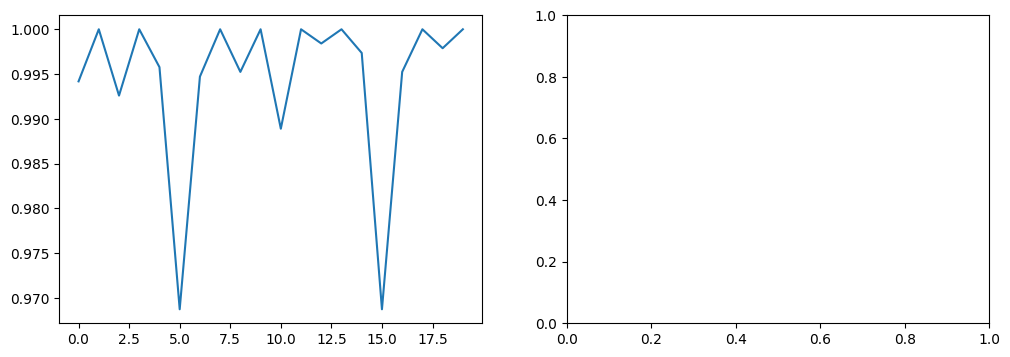

In [27]:
# Ploting training history

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history2)

# Print final metrics
final_train_accuracy = history2.history['accuracy'][-1]
final_val_accuracy = history2.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")